# PyTorch VAE and GAN

## References

#### VAE
* [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
* [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)

#### GAN
* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)
* [Improved Techniques for Training GANs](http://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

## Load Data

In [18]:
import matplotlib
%matplotlib inline

from torchvision import transforms, datasets, utils
import torch
import matplotlib.pyplot as plt
import numpy as np

In [19]:
tfms = transforms.ToTensor()

In [20]:
trainset = datasets.MNIST(root='~/Code/dl/datasets', train=True, download=True, transform=tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
print(f'Number of training samples: {len(trainset)}')

testset = datasets.MNIST(root='~/Code/dl/datasets', train=False, download=True, transform=tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size=2048, shuffle=True, num_workers=4)
print(f'Number of testing samples: {len(testset)}')

Number of training samples: 60000
Number of testing samples: 10000


In [21]:
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [41]:
dimensions = (1, 28, 28)

In [42]:
def display(img):
    img = img.reshape(*dimensions)
    plt.imshow(img, cmap="Gray")
#     plt.imshow(np.transpose(img, (1, 2, 0)))

frog


TypeError: Invalid dimensions for image data

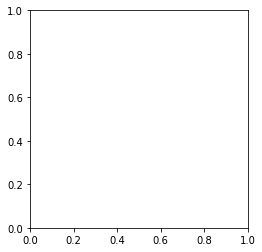

In [159]:
images, labels = iter(trainloader).next() # get first batch

print(classes[labels[0]])
display(images[0])

## VAE

### Model Definition

In [44]:
from torch import nn
from torch.nn import functional as F

In [91]:
# maps image to µ and σ of approximate gaussian posterior
class VAE(nn.Module):
    def __init__(self, inp_len, latent_size):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(inp_len, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200),
            nn.ReLU()
        )
        self.mu = nn.Linear(200, latent_size)
        self.sigma = nn.Linear(200, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, inp_len),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        return self.mu(encoded), self.sigma(encoded)
    
    def decode(self, z):
        return self.decoder(z).view(-1, *dimensions)
    
    def random_z(self, mu, sigma):
        return torch.randn_like(mu) * sigma + mu
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.random_z(mu, sigma)
        return self.decode(z), mu, sigma

In [92]:
def kl_loss(mu, sigma):
    sigma_squared = sigma.pow(2)
    return -0.5 * torch.sum(1 + torch.log(sigma_squared) - mu.pow(2) - sigma_squared)

In [93]:
def recon_loss(pred, inp):
    return F.binary_cross_entropy(pred, inp, size_average=False)

### Training

In [94]:
device = torch.device('cuda')

vae = VAE(int(np.product(dimensions)), 20).to(device)

In [95]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [96]:
vae.train()
epochs = 10
for epoch in range(epochs):
    print(f'\nEPOCH {epoch + 1}/{epochs}')
    
    total_loss = 0
        
    for i, (data, _) in enumerate(trainloader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon, mu, sigma = vae(data)
        loss = recon_loss(recon, data) + kl_loss(mu, sigma)
        total_loss += loss

        loss.backward() 
        optimizer.step()
    
    print(f'Average loss: {total_loss / len(trainloader.dataset)}')


EPOCH 1/10
Average loss: 287.4158935546875

EPOCH 2/10
Average loss: 257.9986267089844

EPOCH 3/10
Average loss: 254.8619842529297

EPOCH 4/10
Average loss: 248.59332275390625

EPOCH 5/10
Average loss: 246.58303833007812

EPOCH 6/10
Average loss: 244.76605224609375

EPOCH 7/10
Average loss: 243.5786590576172

EPOCH 8/10
Average loss: 242.6600341796875

EPOCH 9/10
Average loss: 242.0276641845703

EPOCH 10/10
Average loss: 241.52728271484375


### Testing

In [148]:
from random import choice

In [146]:
def test_cycle(img):
    generated, _, _ = vae.forward(img.unsqueeze(0).to(device))
    generated = generated.detach().cpu().squeeze(0)

    print('Original on left, generated on right')
    grid = utils.make_grid([img, generated])
    plt.imshow(np.transpose(grid, (1, 2, 0)))

Original on left, generated on right


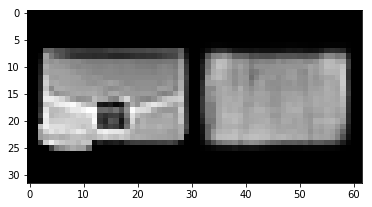

In [156]:
test_cycle(choice(trainset)[0])

In [172]:
def test_random():
    generated = vae.decode(torch.randn((1, 20)).to(device))
    generated = generated.detach().cpu().squeeze().numpy()
    
    plt.imshow(generated, cmap='gray')

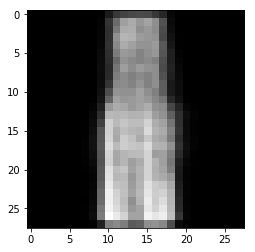

In [173]:
test_random()

In [ ]:
def test_interpolate(start, end, n_steps=16):
    
    